# Data preparation for spatial optimization 
* `candiInfo` - gpd.DataFrame of candidate hub locations, with landprice 
* `infoGrid` - gpd.DataFrame of supply and demand for wood 
* `costMatrix` - np.array of cost matrix from all hubs to all destinations 

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import shapely
import spaghetti
pd.options.mode.chained_assignment = None  # default='warn'

C:\Users\tpytsui\Miniconda\envs\geo_env\Lib\site-packages\spaghetti\network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


# Study area boundary
xmin, xmax, ymin, ymax of boundary for study area. Currently it is the bounding box of amsterdam.

In [2]:
# bounding box of ams: 
bounds = np.array([98034.63572185, 466256.83004902, 143001.39747729, 509186.04208061])

# `candiInfo`
* estimate industrial land price using spatial interpolation
* save file

In [3]:
# modules for spatial interpolation
from pykrige.ok import OrdinaryKriging
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

## Industrial land data - ibis
columns of interest: 
* `HA_BRUTO` - bruto oppervlak (ha) - Gross area (in ha) of the work site
* `PLAN_FASE` - Planfase - planning phase
* `MN_VPRIJS`, `MX_VPRIJS` - gebruik van minimum en maximum verkoopprijs - use of minimum and maximum selling price
* `MN_EPRIJS`, `MX_EPRIJS` - gebruik van minimum en maximum efpachtprijs - use of minimum and maximum leasehold price
* `MILIEUZONE` - milieuzonering - environmental zoning
* `WLOC_TYPE` - type werklocatie - type of work location
* `MAX_MILIEU` - maximale milieucategorie - maximum environmental category

### read data, formatting

In [4]:
ibisFile = gpd.read_file('../_bigData/Ibis 2021/ibis2021_fixed.shp')

In [5]:
ibis = ibisFile[['RIN_NUMMER', 'HA_BRUTO', 'PLAN_FASE','MX_VPRIJS', # MX_VPRIJS was chosen for most non-zero values
                 'MILIEUZONE', 'WLOC_TYPE', 'MAX_MILIEU', 'geometry']] 
ibis = ibis[ibis.MAX_MILIEU != 'X']
ibis.MAX_MILIEU = ibis.MAX_MILIEU.map(lambda x: int(x))
ibis = ibis[(ibis.MAX_MILIEU == 2) | (ibis.MAX_MILIEU == 3)]
ibis.geometry = ibis.geometry.centroid
# ibis.to_file("../_bigData/Ibis 2021/ibis2021_maxMilieu_2-3.shp")

In [6]:
# load data 
nl = gpd.read_file('../_bigData/nlMaps/nl_pc2_amersfoort.shp')
landPrice = ibis[ibis.MX_VPRIJS > 0][['RIN_NUMMER', 'MAX_MILIEU', 'MX_VPRIJS', 'geometry']]

In [7]:
# Get X and Y coordinates of rainfall points
x_landPrice = landPrice["geometry"].x
y_landPrice = landPrice["geometry"].y

# Create lists of XY coordinate pairs, and landprice values
coords_landPrice = [list(xy) for xy in zip(x_landPrice, y_landPrice)]
value_landPrice = list(landPrice["MX_VPRIJS"])

In [8]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

In [9]:
# Split data into testing and training sets
coords_landPrice_train, coords_landPrice_test, value_landPrice_train, value_landPrice_test = train_test_split(coords_landPrice, value_landPrice, 
                                                                                                              test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
landPrice_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_landPrice_train], crs = 'EPSG:28992')
landPrice_train_gdf["Actual_Value"] = value_landPrice_train
landPrice_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_landPrice_test], crs = 'EPSG:28992')
landPrice_test_gdf["Actual_Value"] = value_landPrice_test

# Get minimum and maximum coordinate values of rainfall training points
min_x_landPrice, min_y_landPrice, max_x_landPrice, max_y_landPrice = landPrice.total_bounds

### spatial interpolation

PyKrige Kriging out-of-sample r-squared: 0.82

Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


,RIN_NUMMER,MAX_MILIEU,MX_VPRIJS,geometry,VALUE_Predict
34,4873,3,300.0,POINT (130198.315 459226.671),282.974159
60,155001,3,320.0,POINT (157234.665 466327.512),303.701128


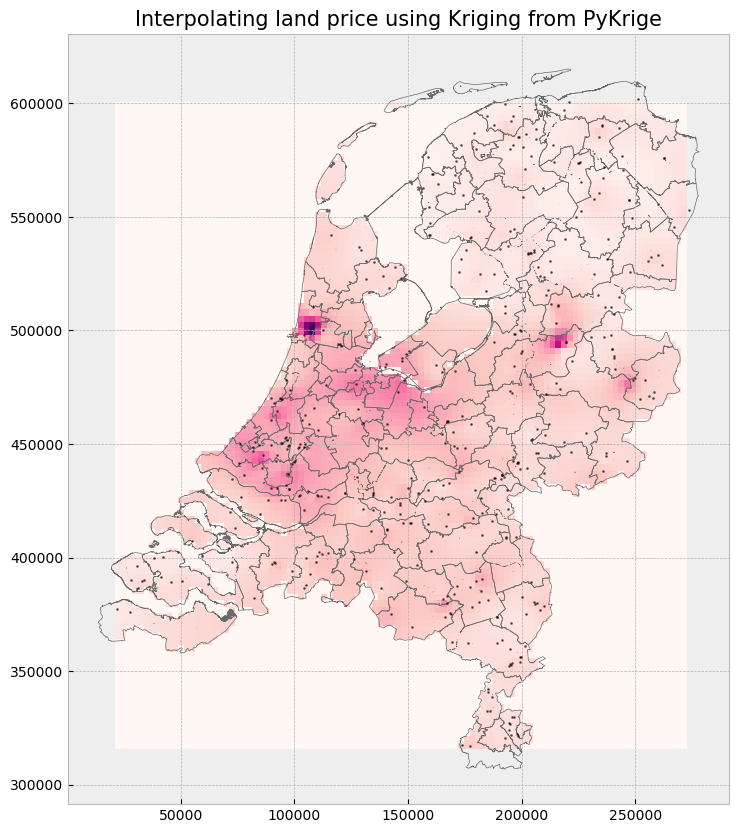

In [10]:
# may be one of the following: linear, power, gaussian, spherical, exponential, hole-effect
variogramModel = "exponential" # exponential leads to highest r-value

# Create a 100 by 100 grid
# Horizontal and vertical cell counts should be the same
XX_pk_krig = np.linspace(min_x_landPrice, max_x_landPrice, 100)
YY_pk_krig = np.linspace(min_y_landPrice, max_y_landPrice, 100)

# Generate ordinary kriging object
OK = OrdinaryKriging(
    np.array(x_landPrice), # x (array_like) – X-coordinates of data points
    np.array(y_landPrice), # y (array_like) – Y-coordinates of data points
    value_landPrice, # z (array-like) – Values at data points
    variogram_model = variogramModel,
    verbose = False,
    enable_plotting = False,
    coordinates_type = "euclidean",
)

Z_pk_krig, sigma_squared_p_krig = OK.execute(
    "grid", # Specifies how to treat input kriging points. Specifying ‘grid’ treats xpoints and 
    # ypoints as two arrays of x and y coordinates that define a rectangular grid
    XX_pk_krig, # x coordinates of grid
    YY_pk_krig # y coordinates of grid 
)

rasterPath = "results/landPrice_pk_kriging_{}.tif".format(variogramModel)

# Export raster
export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x_landPrice, max_x = max_x_landPrice, min_y = min_y_landPrice, max_y = max_y_landPrice,
                  proj = 'EPSG:28992', filename = rasterPath)

# Open raster
raster_pk = rasterio.open(rasterPath)


# Create polygon with extent of raster
poly_shapely = box(*raster_pk.bounds)

# Create a dictionary with needed attributes and required geometry column
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

# Convert shapely object to a GeoDataFrame
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = 'EPSG:28992')

# Create copy of test dataset
# landPrice_withZeros = ibis[['MX_VPRIJS', 'geometry']]
landPrice_krig = landPrice.copy()

# Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
landPrice_krig = landPrice_krig[landPrice_krig.within(raster_pk_extent.geometry.values[0])]

# Create list of XY coordinate pairs for the test points that fall within raster extent polygon
coords_landPrice_krig = [list(xy) for xy in zip(landPrice_krig["geometry"].x, landPrice_krig["geometry"].y)]

# Extract raster value at each test point and add the values to the GeoDataFrame
landPrice_krig["VALUE_Predict"] = [x[0] for x in raster_pk.sample(coords_landPrice_krig)]

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(landPrice_krig.MX_VPRIJS, landPrice_krig.VALUE_Predict)
print("PyKrige Kriging out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))

# Display attribute table
print("\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method")
display(landPrice_krig.head(2))

# Mask raster to counties shape
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, nl.geometry.values, crop = True)

# Stylize plots
plt.style.use('bmh')

# Plot data
fig, ax = plt.subplots(1, figsize = (10, 10))
show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = "RdPu")
ax.plot(x_landPrice, y_landPrice, 'k.', markersize = 2, alpha = 0.5)
nl.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

# Set title
ax.set_title('Interpolating land price using Kriging from PyKrige', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()

raster_pk.close()

In [11]:
# apply the raster created from spatial interpolation onto zero values of ibis dataset
# Open raster
raster_pk = rasterio.open(rasterPath)
poly_shapely = box(*raster_pk.bounds)
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = 'EPSG:28992')

# Create copy of ibis dataset with zeros
landPrice_krig = ibis.copy()
landPrice_krig = landPrice_krig[['RIN_NUMMER', 'MAX_MILIEU', 'geometry']]

# Extract raster value at each test point and add the values to the GeoDataFrame
landPrice_krig = landPrice_krig[landPrice_krig.within(raster_pk_extent.geometry.values[0])]
coords_landPrice_krig = [list(xy) for xy in zip(landPrice_krig["geometry"].x, landPrice_krig["geometry"].y)]
landPrice_krig["VALUE_Predict"] = [x[0] for x in raster_pk.sample(coords_landPrice_krig)]

# closer raster
raster_pk.close()

### plot results of spatial interpolation

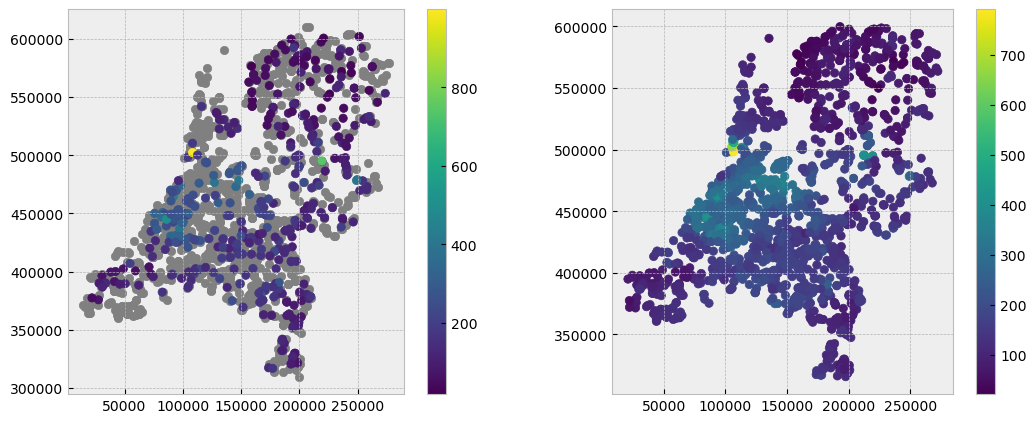

In [12]:
# plot
fig, ax = plt.subplots(1,2,figsize=(13,5))
landPrice.plot(ax=ax[0], column='MX_VPRIJS', legend=True)
zeros = ibis[ibis.MX_VPRIJS == 0]
zeros.plot(ax=ax[0], color='grey', zorder=-1)
landPrice_krig.plot(ax=ax[1], column='VALUE_Predict', legend=True)
plt.show()

In [14]:
candiInfo = landPrice_krig.copy()
candiInfo = candiInfo.rename(columns={'VALUE_Predict': 'pPerSqm'})
candiInfo.head()

,RIN_NUMMER,MAX_MILIEU,geometry,pPerSqm
0,155063,3,POINT (165003.724 454509.880),194.823183
2,262017002,3,POINT (164667.725 454390.949),194.823183
4,4949,3,POINT (165193.864 454475.457),194.823183
5,155019,3,POINT (147049.021 465588.471),319.543937
8,4925,3,POINT (149174.081 469885.487),340.799785


# `infoGrid`
* filter PBL dataset to show only future supply and demand for next 5 years

In [15]:
# gdf of supply of secondary resources 
supply = gpd.read_file('../_bigData/pblUrbanMiningModels/shpsCleaned/supply_NL.shp')
# xmin, ymin, xmax, ymax = bounds
# supply = supply.cx[xmin:xmax, ymin:ymax]
supply = supply.reset_index(drop=True)

# gdf of demand for secondary resources
demand = gpd.read_file('../_bigData/pblUrbanMiningModels/shpsCleaned/demand_NL.shp')
# xmin, ymin, xmax, ymax = bounds
# demand = demand.cx[xmin:xmax, ymin:ymax]
demand = demand.reset_index(drop=True)

In [16]:
# extract cells most likely to be demolished in next 5 years 

# supplyPot - demolition locations in next 5 years
supplyPot = supply[supply.buildYear > 1920]
supplyPot = supplyPot.sort_values('buildYear')
nRows = int(len(supplyPot) / 6) # oldest 1/6 of cells  
supplyPot = supplyPot.head(nRows)
supplyPot = supplyPot[['wood', 'geometry']]
supplyPot = supplyPot.rename(columns={'wood': 'totKgSupply'})

# demandPot - construction locations for next 5 years
demandPot = demand.sample(int(len(demand) / 6)) # random 1/6 of cells
demandPot = demandPot[['wood', 'geometry']]
demandPot = demandPot.rename(columns={'wood': 'totKgDemand'})

In [17]:
# make grid of points with resolution 100 x 100 m, wihtin bounds
xmin, ymin, xmax, ymax = demand.buffer(1000).total_bounds
cell_size = 100
crs = 'EPSG:28992'
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs).reset_index()

In [20]:
# values for demandPot
temp = gpd.sjoin(cell, demandPot, how='left')
temp = temp[~temp.totKgDemand.isna()]
temp.reset_index(inplace=True)
demValues = temp[['index', 'totKgDemand']].groupby(by='index').sum().reset_index()

# values for supplyPot 
temp = gpd.sjoin(cell, supplyPot, how='left')
temp = temp[~temp.totKgSupply.isna()]
temp.reset_index(inplace=True)
supValues = temp[['index', 'totKgSupply']].groupby(by='index').sum().reset_index()

# merge
infoGrid = cell.merge(demValues, on='index', how='left') # merge dem
infoGrid = infoGrid.merge(supValues, on='index', how='left') # merge sup 
infoGrid = infoGrid[~infoGrid.totKgDemand.isna() | ~infoGrid.totKgSupply.isna()]
infoGrid = infoGrid.fillna(0)

# turn polygons into centroids
infoGrid.geometry = infoGrid.geometry.centroid
infoGrid.head()

,index,geometry,totKgDemand,totKgSupply
31135,31135,POINT (15400.000 378200.000),101176.485772,0.0
31136,31136,POINT (15400.000 378300.000),101176.485772,0.0
34178,34178,POINT (15500.000 378200.000),101176.485772,0.0
34179,34179,POINT (15500.000 378300.000),101176.485772,0.0
46274,46274,POINT (15900.000 370600.000),104305.558944,0.0


<AxesSubplot: >

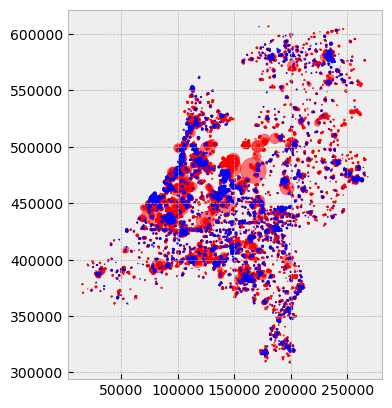

In [21]:
ax = infoGrid.plot(markersize=infoGrid.totKgDemand/100000, color='red', alpha=0.5)
infoGrid.plot(markersize=infoGrid.totKgSupply/100000, color='blue', alpha=0.5, ax=ax)

# `costMatrix`

In [49]:
xmin, ymin, xmax, ymax = bounds
candiInfoAms = candiInfo.cx[xmin:xmax, ymin:ymax]
infoGridAms = infoGrid.cx[xmin:xmax, ymin:ymax]

In [13]:
# streets, facilities, clients
candiInfoAms = gpd.read_file('data/candiInfo_ams.shp')
infoGridAms = gpd.read_file('data/infoGrid_ams.shp')
infoGridAms.rename(columns={'totKgDeman': 'totKgDemand', 
                           'totKgSuppl': 'totKgSupply'}, 
                   inplace=True)
streetsAms = gpd.read_file('data/roads/ams_edges.shp')
facilities = candiInfoAms.copy()
clients = infoGridAms.copy()
clients = clients[['totKgSupply', 'totKgDemand', 'geometry']]

In [14]:
%%time
ntw = spaghetti.Network(in_data=streetsAms)

CPU times: total: 484 ms
Wall time: 500 ms


In [24]:
def makeCostMatrix(facilities, clients=clients, ntw=ntw, streets=streets): 
    ntw.snapobservations(clients, "clients", attribute=True)
    # clients_snapped = spaghetti.element_as_gdf(
    #     ntw, pp_name="clients", snapped=True
    # )
    ntw.snapobservations(facilities, "facilities", attribute=True)
    # facilities_snapped = spaghetti.element_as_gdf(
    #     ntw, pp_name="facilities", snapped=True
    # )
    cost_matrix = ntw.allneighbordistances(
        sourcepattern=ntw.pointpatterns["clients"],
        destpattern=ntw.pointpatterns["facilities"],
    )
    
    return cost_matrix

In [32]:
ntw.pointpatterns["clients"]

In [25]:
costMatrixAms = makeCostMatrix(facilities, clients)

In [17]:
costMatrixAms[:3, :3]

array([[36218.17190359, 37827.61012227, 33393.6831965 ],
       [36218.17190619, 37827.61012487, 33393.6831991 ],
       [36280.48505503, 37889.92327371, 33455.99634793]])

In [37]:
costMatrixAms[0]

array([36218.17190359, 37827.61012227, 33393.6831965 , 39907.56111898,
       40053.22411445, 52433.00533792, 54905.5037527 , 54962.79838683,
       57141.90505997, 52135.60308314, 51327.44672039, 26516.05964434,
       26709.42188595, 16204.17353786, 24000.58369086, 32896.32776356,
        7284.02893932, 16356.26640212, 33600.88595137, 34743.01890288,
       20219.39373194, 14485.76453023, 47685.69163967, 26279.38689008,
       31357.10333084, 30730.32759165, 13676.71907026, 31739.289914  ,
       29823.29306841, 30991.81209476, 15525.8359496 , 15118.23759694,
       53034.35371267, 52403.10753049, 21923.89033636, 26944.58899383,
       36053.28091625, 24893.73863055, 42828.26538499, 22786.70977375,
       21474.52869079, 25065.27235532, 24150.25278876, 35310.25275544,
       20879.01929825, 21201.62848623, 13549.50993926, 35310.25275544,
       31556.81924897, 31143.77142799, 37972.79902114, 37291.96307922,
       32514.26073438, 15413.77673335, 35549.09148541, 49864.10744302,
      

In [58]:
costMatrixAms[:3, :3]

array([[ 504.96323618, 2301.47830329,  725.80017994],
       [ 461.37284284, 2257.88790996,  682.20978661],
       [ 406.97133779, 2203.4864049 ,  627.80828155]])

# Save data 
save `candiInfo`, `infoGrid`, and `costMatrix`. Don't forget to change filename to reflect study area (e.g. _ams)

## save data for whole country

In [24]:
candiInfo.to_file('data/candiInfo_nl.shp')
infoGrid.to_file('data/infoGrid_nl.shp')

C:\Users\tpytsui\AppData\Local\Temp\ipykernel_1936\1431429095.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  infoGrid.to_file('data/infoGrid_nl.shp')


## save data for study area (amsterdam)

In [59]:
np.save('data/costMatrix_ams.npy', costMatrixAms)
infoGridAms.to_file('data/infoGrid_ams.shp')
candiInfoAms.to_file('data/candiInfo_ams.shp')

C:\Users\tpytsui\AppData\Local\Temp\ipykernel_1936\4001452969.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  infoGridAms.to_file('data/infoGrid_ams.shp')
